# Project 03

**Submitted by: Diego Sol**

CSCE 636-600: Deep Learning

Professor: Dr. Anxiao Jiang

----------------

**This project is on language modeling for an artificial language. We want to build a model such that given a "partial text" in the artificial language, the model can predict the next word.**

**Your task is to design and train a good model, which takes "partial texts" as input, and predicts the "next word" for each "partial text".**

**Your trained model will be evaluated using a hold-out testing set. The testing set also consists of a list of "partial texts" (as the model's input) and a list of "next word" (to be compared to your model's output). In the list of "partial texts", each "partial text" is a list of words instead of a single string, just like the "partial texts" above that we have for the training set. The performance of your model will be measured by its "accuracy for words", defined as the fraction of "next words" that your model correctly predicts.**

# Initialization

**This section includes mounting the session to Google Drive, importing necessary libraries to run the file, and downloading and reformatting the training datasets.**

## Mount Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [2]:
import pickle
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

rng = np.random.default_rng()

## Import Data

Download training inputs and outputs.

In [40]:
raw_train_input = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/CSCE_636_Project_3/DS_5_train_output', 'rb'))
prefix_list = np.asarray(pickle.load(open('/content/drive/MyDrive/Colab Notebooks/CSCE_636_Project_3/DS_5_train_input_prefixList', 'rb')))
nextWord_list = np.asarray(pickle.load(open('/content/drive/MyDrive/Colab Notebooks/CSCE_636_Project_3/DS_5_train_input_nextWord', 'rb')))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


## Pre-process Data

Remove spaces from the data the contains complete sentences. We see that the longest complete sentence contains 64 words.

In [57]:
s = " "
vocabulary = []

for i, sentence in enumerate(raw_train_input):
  vocabulary.append(sentence.replace(s, ""))

len(max(vocabulary,key=len))

64

We also see that the longest string in the training data contains 48 words. Therefore, we only need to pad up to 48 to make all of the sequences equal in length.

In [58]:
len(max(prefix_list,key=len))

48

Convert downloaded data into a list of padded strings of the same length for training.

In [60]:
train_input = []

for i, phrase in enumerate(prefix_list):
  train_input.append(s.join(phrase))

print(train_input[0])

a g b f a f a e a k a j c f b f c d a k


Pad the input data using the `TextVectorization` layer.


In [68]:
input_vectorization = layers.TextVectorization(output_sequence_length=100)
input_vectorization.adapt(train_input)

output_vectorization = layers.TextVectorization(output_sequence_length=1)
output_vectorization.adapt(nextWord_list)

train_input_vec = input_vectorization(train_input)
train_output_vec = output_vectorization(nextWord_list)

print(train_input_vec[0])
print(train_output_vec[0])

tf.Tensor(
[ 2  8  3  7  2  7  2  5  2  9  2 11  4  7  3  7  4  6  2  9  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0], shape=(100,), dtype=int64)
tf.Tensor([2], shape=(1,), dtype=int64)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100)]             0         
                                                                 
 dense_8 (Dense)             (None, 32)                3232      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 13)                429       
                                                                 
Total params: 5,773
Trainable params: 5,773
Non-trainable params: 0
_________________________________________________________________


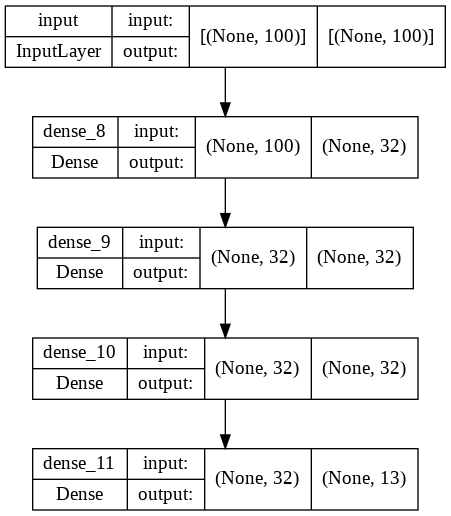

In [71]:
inputs = keras.Input(shape=(100), name="input")
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(13, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(train_input_vec,train_output_vec,
                    validation_split = 0.3,
                    epochs = 15,
                    batch_size=32)

